Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 47s 943us/sample - loss: 1.4839 - accuracy: 0.4609 - val_loss: 1.2186 - val_accuracy: 0.5618
Epoch 2/10
50000/50000 [==============================] - 49s 989us/sample - loss: 1.1261 - accuracy: 0.6016 - val_loss: 1.0409 - val_accuracy: 0.6270
Epoch 3/10
50000/50000 [==============================] - 55s 1ms/sample - loss: 0.9813 - accuracy: 0.6556 - val_loss: 0.9818 - val_accuracy: 0.6531
Epoch 4/10
50000/50000 [==============================] - 59s 1ms/sample - loss: 0.8858 - accuracy: 0.6904 - val_loss: 0.9206 - val_accuracy: 0.6793
Epoch 5/10
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.8145 - accuracy: 0.7145 - val_loss: 0.8790 - val_accuracy: 0.6946
Epoch 6/10
50000/50000 [==============================] - 58s 1ms/sample - loss: 0.7506 - accuracy: 0.7365 - val_loss: 0.8679 - val_accuracy: 0.7002
Epoch 7/10
50000/50000 [============================

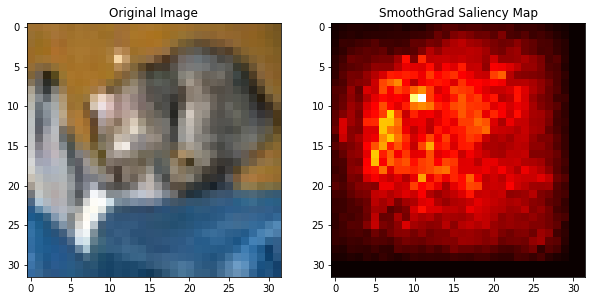

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 加载并预处理CIFAR-10数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 构建简单的CNN模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# 选择测试集中的一张图像进行可视化
image_index = 0
image = x_test[image_index:image_index+1]
label = y_test[image_index]

# 转换为张量并确保数据类型为float32
image = tf.convert_to_tensor(image, dtype=tf.float32)
label = tf.convert_to_tensor(label, dtype=tf.float32)

def compute_saliency_maps(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, predictions)
    gradient = tape.gradient(loss, image)
    return tf.abs(gradient)

def smooth_grad(image, label, n_samples=50, noise_level=0.1):
    smooth_grad = tf.zeros_like(image, dtype=tf.float32)
    for i in range(n_samples):
        noise = tf.random.normal(shape=image.shape, mean=0.0, stddev=noise_level, dtype=tf.float32)
        noisy_image = image + noise
        grad = compute_saliency_maps(noisy_image, label)
        smooth_grad += grad
    return smooth_grad / n_samples

# 计算SmoothGrad显著图
smooth_saliency_map = smooth_grad(image, label)

# 取最大通道值并去掉批次维度
smooth_saliency_map = tf.reduce_max(smooth_saliency_map, axis=-1)[0]

# 可视化原图像和SmoothGrad显著图
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image[0])

plt.subplot(1, 2, 2)
plt.title("SmoothGrad Saliency Map")
plt.imshow(smooth_saliency_map, cmap='hot')

plt.show()
